<a href="https://colab.research.google.com/github/dustinwicker/heart_disease_detection/blob/master/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from math import sqrt
import seaborn as sns
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# Increase maximum width in characters of columns - will put all columns in same line in console readout
pd.set_option('expand_frame_repr', False)
# Be able to read entire value in each column (no longer truncating values)
pd.set_option('display.max_colwidth', -1)
# Increase number of rows printed out in console
pd.set_option('display.max_rows', 200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


Load in Data Set and create DataFrame

In [0]:
# Open Hungarian data set
with open('hungarian.data', 'r') as myfile:
    file = []
    for line in myfile:
        line = line.replace(" ", ", ")
        # Add comma to end of each line
        line = line.replace(os.linesep, ',' + os.linesep)
        line = line.split(', ')
        file.extend(line)

file = [value.replace(",\n", "") for value in file]
# Remove empty strings from list
file = list(filter(None, file))

# Convert list to lists of list
attributes_per_patient = 76
i = 0
new_file = []
while i < len(file):
    new_file.append(file[i:i+attributes_per_patient])
    i += attributes_per_patient

# List of column names
headers = ['id', 'ccf', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp', 'trestbps', 'htn', 'chol',
           'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop',
           'nitr', 'pro', 'diuretic', 'proto', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps',
           'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm',
           'exerckm', 'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo',
           'cday', 'cyr', 'num', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox',
           'rcadist', 'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name']

# Convert lists of list into DataFrame and supply column names
hungarian = pd.DataFrame(new_file, columns=headers)

# List of columns to drop
cols_to_drop =['ccf', 'pncaden', 'smoke', 'cigs', 'years', 'dm', 'famhist', 'dig', 'ca', 'restckm', 'exerckm',
               'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'lmt',
               'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 'lvx1',
               'cathef', 'junk', 'name', 'thaltime', 'xhypo', 'slope', 'dummy', 'lvx1', 'lvx2']

# Drop columns from above list
hungarian = hungarian.drop(columns=cols_to_drop)

# Convert all columns to numeric
hungarian = hungarian.apply(pd.to_numeric)

Data Cleaning

In [83]:
## Fix possible patient id issues
# Find ids that are not unique to patients
print(hungarian.id.value_counts()[hungarian.id.value_counts()!=1])

# Fix id 1132 (two different patients are both assigned to this id) - give second patient next id number (id max + 1)
hungarian.loc[139,'id'] = hungarian.id.max() + 1

1132    2
Name: id, dtype: int64


In [0]:
# Method to scale continuous and binary variables (z-score standardization)
scaler = StandardScaler()

In [85]:
# Determine number of missing values for each patient (-9 is the missing attribute value)
# Drop patients with "significant" number of missing values in record (use 10%, can adjust accordingly)
### Also do analysis with keeping all patients regardless of number of missing values ###
# Determine missing value percentage per patient
missing_value_perc_per_patient = (hungarian == -9).sum(axis=1)[(hungarian == -9).sum(axis=1) > 0]\
                                     .sort_values(ascending=False)/len([x for x in hungarian.columns if x != 'id'])

# Remove patients with > 10% missing values
hungarian = hungarian.drop(missing_value_perc_per_patient[missing_value_perc_per_patient>0.10].index.values)

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x: x[1])

### Use KNN to impute missing values ###

variables_not_to_use_for_imputation = ['ekgday', 'cmo', 'cyr', 'ekgyr', 'cday', 'ekgmo', 'num']

# Impute htn
impute_variable = 'htn'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use
fix_htn = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'nitr', 'pro', 'diuretic', 'exang',
                           'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_htn[value], prefix=value)
    fix_htn = fix_htn.join(one_hot)
    fix_htn = fix_htn.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_htn) if x != impute_variable]

# Create DataFrame with missing value(s) to predict on
predict = fix_htn.loc[fix_htn[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_htn.loc[~(fix_htn[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit and transform scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
htn_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print(f'The prediction for htn is {htn_prediction[0]}.')

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'htn'] = htn_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute restecg
impute_variable = 'restecg'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - added in 'htn'
fix_restecg = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'nitr', 'pro', 'diuretic', 'exang',
                           'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_restecg[value], prefix=value)
    fix_restecg = fix_restecg.join(one_hot)
    fix_restecg = fix_restecg.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_restecg) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_restecg.loc[fix_restecg[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_restecg.loc[~(fix_restecg[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit and transform scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
restecg_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print(f'The prediction for restecg is {restecg_prediction[0]}.')

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'restecg'] = restecg_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute prop
# Set y variable
impute_variable = 'prop'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'htn'
fix_prop = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'nitr', 'pro', 'diuretic', 'exang',
                           'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_prop[value], prefix=value)
    fix_prop = fix_prop.join(one_hot)
    fix_prop = fix_prop.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_prop) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_prop.loc[fix_prop[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_prop.loc[~(fix_prop[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit and transform scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
prop_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print(f'The prediction for prop is {prop_prediction[0]}.')

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'prop'] = prop_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute thaldur
# Set y variable
impute_variable = 'thaldur'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'prop'
fix_thaldur = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_thaldur[value], prefix=value)
    fix_thaldur = fix_thaldur.join(one_hot)
    fix_thaldur = fix_thaldur.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_thaldur) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_thaldur.loc[fix_thaldur[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_thaldur.loc[~(fix_thaldur[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
thaldur_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The prediction for thaldur is " + str(thaldur_prediction[0]) + ".")
# Round thaldur_prediction to integer
thaldur_prediction = round(number=thaldur_prediction[0])
print("The prediction for thaldur has been rounded to " + str(thaldur_prediction) + ".")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'thaldur'] = thaldur_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute rldv5
# Set y variable
impute_variable = 'rldv5'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'prop'
fix_rldv5 = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_rldv5[value], prefix=value)
    fix_rldv5 = fix_rldv5.join(one_hot)
    fix_rldv5 = fix_rldv5.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_rldv5) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_rldv5.loc[fix_rldv5[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_rldv5.loc[~(fix_rldv5[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
rldv5_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The prediction for rldv5 is " + str(rldv5_prediction[0]) + ".")
# Round rldv5_prediction to integer
rldv5_prediction = round(number=rldv5_prediction[0])
print("The prediction for rldv5 has been rounded to " + str(rldv5_prediction) + ".")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, 'rldv5'] = rldv5_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute met
# Set y variable
impute_variable = 'met'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'rldv5'
fix_met = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_met[value], prefix=value)
    fix_met = fix_met.join(one_hot)
    fix_met = fix_met.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_met) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_met.loc[fix_met[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_met.loc[~(fix_met[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
met_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for met are:")
print(met_prediction)

# Round met_prediction to integer
for i in range(len(met_prediction)):
    met_prediction[i] = round(number=met_prediction[i])
    print("The prediction for met_prediction" + "[" + str(i) + "]" + " has been rounded to " + str(met_prediction[i]) + ".")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = met_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute fbs
# Set y variable
impute_variable = 'fbs'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'met'
fix_fbs = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_fbs[value], prefix=value)
    fix_fbs = fix_fbs.join(one_hot)
    fix_fbs = fix_fbs.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_fbs) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_fbs.loc[fix_fbs[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_fbs.loc[~(fix_fbs[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
fbs_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for fbs are:")
print(fbs_prediction)

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = fbs_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute fbs
# Set y variable
impute_variable = 'proto'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'fbs'
fix_proto = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'fbs', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'exang', 'lvx3', 'lvx4', 'lvf']

# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_proto[value], prefix=value)
    fix_proto = fix_proto.join(one_hot)
    fix_proto = fix_proto.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_proto) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_proto.loc[fix_proto[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_proto.loc[~(fix_proto[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)
# Transform train_x
train_x = scaler.transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")

# Predict value for predict_y
proto_prediction = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for proto are:")
print(proto_prediction)

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = proto_prediction

# Imputing missing values (marked as -9 per data dictionary)
cols_with_missing_values = [(col, hungarian[col].value_counts()[-9]) for col in list(hungarian) if -9 in hungarian[col].unique()]
# Sort tuples by number of missing values
cols_with_missing_values.sort(key=lambda x:x[1])

# Impute chol
impute_variable = 'chol'

# Obtain list of variables to use for imputation
x_variables = [x for x in list(hungarian) if x not in [x[0] for x in cols_with_missing_values] +
                        variables_not_to_use_for_imputation + ['id']]

# Select x and y variables to use - add in 'fbs'
fix_chol = hungarian[x_variables + [impute_variable]]

# Create list of categorical variables to one-hot encode
categorical_x_variables = ['sex', 'painloc', 'painexer', 'relrest', 'cp', 'htn', 'fbs', 'restecg', 'prop', 'nitr', 'pro',
                           'diuretic', 'proto', 'exang', 'lvx3', 'lvx4', 'lvf']


# One-hot encode categorical variables
for value in categorical_x_variables:
    one_hot = pd.get_dummies(fix_chol[value], prefix=value)
    fix_chol = fix_chol.join(one_hot)
    fix_chol = fix_chol.drop(columns=value)

# Create list of x variables
x_variables = [x for x in list(fix_chol) if x != impute_variable]

# Create DataFrame with missing value(s) - will predict on
predict = fix_chol.loc[fix_chol[impute_variable]==-9]
# Set x and y predict DataFrames
predict_x, predict_y = predict[x_variables], predict[impute_variable]

# Create DataFrame to train on
train = fix_chol.loc[~(fix_chol[impute_variable]==-9)]
# Set x and y train DataFrames
train_x, train_y = train[x_variables], train[impute_variable]

# Fit scaler on train_x
train_x = scaler.fit_transform(train_x)

# Transform predict_x
predict_x = scaler.transform(predict_x)

# Obtain k (number of neighbors) by using sqrt(n)
k = round(sqrt(len(train_x)))
print(f"k is {k}.")

# Check to make sure k is odd number
if divmod(k, 2)[1] == 1:
    print("k is an odd number. Good to proceed.")
else:
    print("Need to make k an odd number.")
    # Substract one to make k odd number
    k -= 1
    print(f"k is now {k}.")

# Predict value for predict_y
chol_prediction = KNeighborsRegressor(n_neighbors=k, metric='minkowski', weights='distance').fit(train_x, train_y).predict(predict_x)
print("The predictions for chol are:")
print(chol_prediction)

# Round chol_prediction to integer
for i in range(0, len(chol_prediction)):
    chol_prediction[i] = round(number=chol_prediction[i])
    print(f"The prediction for chol_prediction [{str(i)}] has been rounded to {chol_prediction[i]}.")

# Supply prediction back to appropriate patient
hungarian.loc[hungarian[impute_variable]==-9, impute_variable] = chol_prediction

k is 17.
k is an odd number. Good to proceed.
The prediction for htn is 0.
k is 17.
k is an odd number. Good to proceed.
The prediction for restecg is 0.
k is 17.
k is an odd number. Good to proceed.
The prediction for prop is 1.
k is 17.
k is an odd number. Good to proceed.
The prediction for thaldur is 11.057187036308397.
The prediction for thaldur has been rounded to 11.0.
k is 17.
k is an odd number. Good to proceed.
The prediction for rldv5 is 12.66158057648588.
The prediction for rldv5 has been rounded to 13.0.
k is 17.
k is an odd number. Good to proceed.
The predictions for met are:
[5.26663321 7.21273683]
The prediction for met_prediction[0] has been rounded to 5.0.
The prediction for met_prediction[1] has been rounded to 7.0.
k is 17.
k is an odd number. Good to proceed.
The predictions for fbs are:
[0 0 0 0 0 0 0 0]
k is 17.
k is an odd number. Good to proceed.
The predictions for proto are:
[100 125 125 100 100 125 125 100 150]
k is 16.
Need to make k an odd number.
k is no

In [0]:
# Set y variable to 0-1 range (as previous studies have done)
hungarian.loc[hungarian.num > 0, "num"] = 1

Cluster dataset

In [0]:
# Create target variable
y = hungarian['num']
# Create feature variables
x = hungarian.drop(columns='num')

In [0]:
# Define parameters of K-means
k_means = KMeans(n_clusters=2)

# Perform k-means cluster
cluster_labels = k_means.fit(x[["age", "trestbps", "met", "thalach", "tpeakbpd", "trestbpd"]]).labels_
# Append labels from cluster back onto DataFrame for analysis
hungarian['cluster_labels'] = cluster_labels

Analysis clustering results

In [89]:
# Groupby cluster label and obtain statistics about variables used to cluster
# What variables are driving my clusters and what patients make up each clusters?
print(hungarian.groupby('cluster_labels')[["age", "trestbps", "met", "thalach", "tpeakbpd", "trestbpd"]].mean())

print(hungarian.groupby('cluster_labels')[["age", "trestbps", "met", "thalach", "tpeakbpd", "trestbpd"]].describe().T)

                      age    trestbps       met     thalach   tpeakbpd   trestbpd
cluster_labels                                                                   
0               51.172662  139.007194  4.743885  119.726619  98.007194  87.000000
1               44.745098  126.633987  6.575817  156.816993  93.601307  81.928105
cluster_labels           0           1
age      count  139.000000  153.000000
         mean   51.172662   44.745098 
         std    6.271546    7.866091  
         min    37.000000   28.000000 
         25%    47.500000   39.000000 
         50%    52.000000   45.000000 
         75%    55.000000   52.000000 
         max    66.000000   62.000000 
trestbps count  139.000000  153.000000
         mean   139.007194  126.633987
         std    17.869290   15.218475 
         min    100.000000  92.000000 
         25%    130.000000  120.000000
         50%    140.000000  120.000000
         75%    150.000000  140.000000
         max    200.000000  180.000000
met      

Visualize clustering results

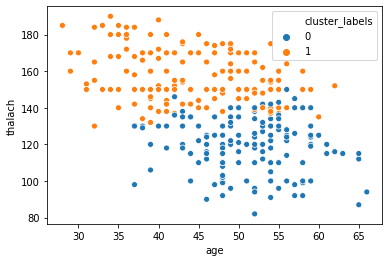

In [90]:
# Scatterplot
sns.scatterplot(x = hungarian['age'], y= hungarian['thalach'], hue=hungarian['cluster_labels'])

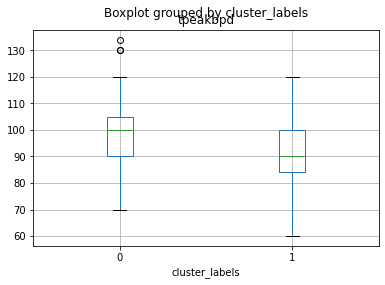

In [91]:
# Boxplot
hungarian.boxplot(column="tpeakbpd", by='cluster_labels')

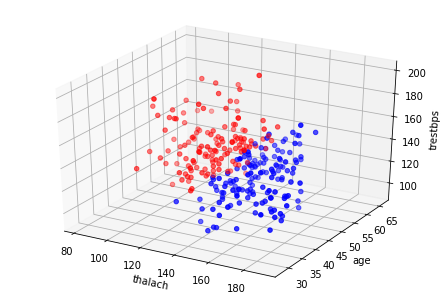

In [92]:
# 3-D plot
fig = pyplot.figure()
ax = Axes3D(fig)
colors = {0:'red', 1:'blue'}
ax.scatter(hungarian['thalach'], hungarian['age'], hungarian['trestbps'], color=hungarian["cluster_labels"].apply(lambda x: colors[x]))
ax.set_xlabel('thalach')
ax.set_ylabel('age')
ax.set_zlabel('trestbps')
pyplot.show()
